In [32]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline 

In [33]:
#Import Data
local_path = r'C:\Users\alons\OneDrive\Documentos\GitHub\Tarea-NSP\\'
datos = pd.read_csv(local_path + 'data_new_features_clean.csv')


In [34]:
#Transform Data into Numerical:

datos['FechaNac'] = pd.to_datetime(datos['FechaNac'])
datos['FechaReserva'] = pd.to_datetime(datos['FechaReserva'])
datos['FechaCita'] = pd.to_datetime(datos['FechaCita'])
datos = datos.sort_values('FechaCita')

In [36]:
#Transform Data into Numerical
from sklearn import preprocessing
le = preprocessing.LabelEncoder()


column_list = [] #str columns
for column in datos.columns:
    if datos[column].dtype == 'O':
        column_list.append(column)

datos_num = datos[column_list].astype(str).apply(le.fit_transform)
for column in datos.columns:
    if datos[column].dtype != 'O':
        datos_num[column] = datos[column]

## Parte 4 SVM

Recordando lo visto en clase, el problema SVM consiste en la separación de un conjunto de observaciones $x_{i} \in \mathbb{R}^{m}$, $i \in \{1,..,n\}$, en este caso de la base de datos ya especificada, donde $n = 122.862$ es la cantidad de observaciones y $m = 13$ es la cantidad de variables a tener en cuenta para el análisis, por su etiqueda correspondiente $y_{i} \in \{'Atendido', 'No Atendido', 'Cancelado'\}$ mediante hiperplanos. 

La siguiente formulación corresponde al caso en que el etiquetado es binario, y existen variables de holgura $\xi_{i}$ que permiten darle factibilidad al problema incluso si los datos no son separables, además de la función $\phi(.)$, que representa una función Kernel. La constante $C \ge 0$ corresponde a la penalización asociada a las holguras, que variaría según se estime conveniente.

%%latex


\begin{equation*}
\begin{aligned}
& \underset{w,b,\xi}{\text{minimize}}
& & \frac{1}{2}w^{T}w + C\sum_{i = 1}^{n}\xi_{i} \\
& \text{subject to}
& & y_{i}(w^{T}\phi(x_{i})+b) \geq 1-\xi_{i} , \; i = 1, \ldots, n.\\
& & & \xi_{i} \geq 0
\end{aligned}
\end{equation*}

El modelo anterior es el que utiliza la librería LIBSVM para el método SVC, que se utilizará para realizar el estudio de la pertinencia de este modelo para el problema NSP. Cabe destacar que es un modelo generalizado para $n$ etiquetas, que en este caso son $\{'Atendido', 'No Atendido', 'Cancelado'\}$, identificadas con los números $\{1,2,4\}$ respectivamente. ESsto para poder correr el modelo.

Dado que se desea trabajar sólo con esas tres etiquetas, se procederá a eliminar aquellas distintas de estas.

In [43]:
##Generación DataFrame con sólo 3 etiquetas posibles: 'Atendido', 'No Atendido', 'Cancelado'
datos_num_three_states = datos_num[(datos_num.EstadoCita != 0) & (datos_num.EstadoCita != 3)
                                                 & (datos_num.EstadoCita != 5)]

Como se mencionó anteriormente, esta es una base de datos desbalanceada respecto a la muestra de etiquetas, como se puede ver en el siguiente gráfico. Los porcentajes de cada cual son los siguientes:

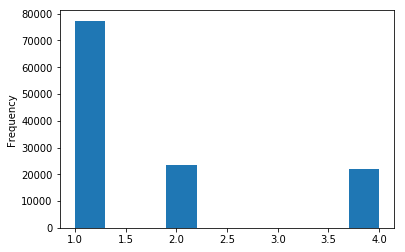

In [44]:
##Gráfico de frecuencias
datos_num_three_states['EstadoCita'].plot.hist()

In [45]:
##Porcentajes de cada etiqueta en todo el DataFrame final.
frecuency = datos_num_three_states.groupby('EstadoCita').count()
print(100*frecuency.iloc[0,1]/(frecuency.iloc[0,1]+frecuency.iloc[1,1]+frecuency.iloc[2,1]), "porcentaje de 'Atendido'")
print(100*frecuency.iloc[1,1]/(frecuency.iloc[0,1]+frecuency.iloc[1,1]+frecuency.iloc[2,1]), "porcentaje de 'Cancelado'")
print(100*frecuency.iloc[2,1]/(frecuency.iloc[0,1]+frecuency.iloc[1,1]+frecuency.iloc[2,1]), "porcentaje de 'No Atendido'")

62.988556266380165 porcentaje de 'Atendido'
19.012387882339535 porcentaje de 'Cancelado'
17.9990558512803 porcentaje de 'No Atendido'


A continuación, se procede a realizar un 'Undersampling' de la etiqueta $'Atendido'$ con un 20% seleccionado aleatoreamente, mientras que se toman un 50% de las restantes de  la misma forma. Esto para generar un conjunto de entrenamiento adecuado para el clasificador de SVM, debido que, dadas pruebas anteriores, al entrenar con una gran cantidad de elementos $'Atendidos'$ se llegaba a que no se reconocían los otros dos tipos de etiquetas, i.e., todo quedaba etiquetado con $'Atendido'$. Esto da como resultado un DataFrame de tamaño $n_{training}=38.215$ y  $ m = 13$. Como consecuencia directa, el conjunto de datos test queda de tamaño $n_{test} = 82.647$ con las mismas $m$ variables. 

In [47]:
##SubDataFrames con las posibles etiiquetas
datos_num_atendidos = datos_num[datos_num.EstadoCita == 1]
datos_num_cancelados = datos_num[datos_num.EstadoCita == 2]
datos_num_no_asistidos = datos_num[datos_num.EstadoCita == 4]

In [48]:
##Shapes de los DataFrames de cada etiqueta.
print("\n",datos_num_atendidos.shape,'shape de Atendidos', "\n",datos_num_cancelados.shape,
      'shape de Cancelados', "\n",datos_num_no_asistidos.shape,'shape de No Atendidos')


 (77389, 25) 
 (23359, 25) 
 (22114, 25)


In [136]:
##Elección de traininng set de forma aleatorea con una semilla.
datos_num_atendidos_training = datos_num_atendidos.sample(frac=0.20, random_state=857)
datos_num_cancelados_training = datos_num_cancelados.sample(frac=0.5, random_state=857)
datos_num_no_asistidos_training = datos_num_no_asistidos.sample(frac=0.5, random_state=857)

In [137]:
##Generación DataFrame final de training set.
datos_num_training = datos_num_atendidos_training.append(datos_num_cancelados_training,sort=False)
datos_num_training = datos_num_training.append(datos_num_no_asistidos_training,sort=False)

Durante el proceso de prueba de SVM como clasificador, se trabajó utilizando diferentes combinaciones de columnas del conjunto de datos para realizar la clasificación. En ello se notó que dada una gran cantidad de columnas, en predictor se volvía volátil y, dependiendo de la cantidad de datos con los que se entrenara de cada etiqueta, los resultados se inclinaban sólo a una. El fenómeno se mitigó al disminuir la cantidad de columnas y probar distintas combinaciones, por lo que, para los resultados que se analizarán, se trabajará con las siguientes variables: Sexo, Comuna, Agenda, TipoProfesional, Especialidad, TipoAtencion, Distancia, Reservas Anteriores, Edad, DiasReservaCita, Dia Cita, Mes Cita, Cancelaciones Anteriores, Atenciones Anteriores.

In [138]:
##Separación etiquetas de los datos, además de quitar aquellas columnas que no queremos que aparezcan.
y = datos_num_training['EstadoCita']
X = datos_num_training.drop(['EstadoCita','FechaNac','FechaReserva','FechaCita','Unnamed: 0','PAID',
                             'Prestacion','Provincia','Region','CodPrestacion','No Atenciones Anteriores'], axis=1)

In [139]:
##Lista de índices.
training_index = list(X.index)

In [140]:
##Generación DataFrame de conjunto test para probar el predictor.
datos_num_test = datos_num_three_states.drop(training_index)
datos_num_test_unlabeled = datos_num_test.drop(['EstadoCita','FechaNac','FechaReserva','FechaCita','Unnamed: 0','PAID',
                                                 'Prestacion','Provincia','Region','CodPrestacion'
                                                ,'No Atenciones Anteriores'], axis=1)
datos_num_test_labels = datos_num_test['EstadoCita']
datos_num_test_unlabeled.shape


(84647, 14)

In [143]:
##Estandarización con ciretio min-max training set
df_training_normalized = (X-X.min())/(X.max()-X.min())
df_training_normalized.head()

,Sexo,Comuna,Agenda,TipoProfesional,Especialidad,TipoAtencion,Distancia,Reservas Anteriores,Edad,DiasReservaCita,Dia Cita,Mes Cita,Cancelaciones Anteriores,Atenciones Anteriores
64202,0.333333,0.474265,0.2,0.333333,0.0,0.333333,0.000000,0.005025,0.040375,0.069597,1.00,0.000000,0.000000,0.01
69810,1.000000,0.632353,0.8,0.666667,1.0,0.333333,0.000000,0.000000,0.033931,0.005495,1.00,0.272727,0.000000,0.00
100759,1.000000,0.551471,0.6,0.666667,1.0,0.666667,0.777778,0.045226,0.096842,0.001832,0.50,0.272727,0.005076,0.08
87829,1.000000,0.680147,0.0,0.666667,1.0,0.666667,0.000000,0.010050,0.172861,0.230769,0.25,0.909091,0.000000,0.02
79915,1.000000,0.959559,0.6,0.666667,1.0,0.666667,0.222222,0.040201,0.146453,0.000000,0.25,0.636364,0.000000,0.07


In [144]:
##Estandarización test set
df_test_normalized = (datos_num_test_unlabeled-datos_num_test_unlabeled.min())/(datos_num_test_unlabeled.max()-datos_num_test_unlabeled.min())
df_test_normalized.head()

,Sexo,Comuna,Agenda,TipoProfesional,Especialidad,TipoAtencion,Distancia,Reservas Anteriores,Edad,DiasReservaCita,Dia Cita,Mes Cita,Cancelaciones Anteriores,Atenciones Anteriores
0,0.333333,1.000000,0.2,0.666667,0.0,0.333333,0.0,0.0,0.080523,0.025641,1.0,0.0,0.0,0.0
26,1.000000,0.632353,0.2,0.666667,0.0,0.333333,0.0,0.0,0.005817,0.078755,1.0,0.0,0.0,0.0
27,0.333333,0.477941,0.2,0.666667,0.0,0.333333,0.0,0.0,0.069859,0.078755,1.0,0.0,0.0,0.0
29,0.333333,0.632353,0.6,0.666667,1.0,0.000000,0.0,0.0,0.040570,0.056777,1.0,0.0,0.0,0.0
30,0.333333,0.632353,0.2,0.666667,0.0,0.666667,0.0,0.0,0.063984,0.020147,1.0,0.0,0.0,0.0


### Comparación SVM con penalización uniforme vs SVM con penalización diferenciada según etiquetas.

Se realiza una predicción con respecto al modelo SVM anteriormente indicado, donde usamos la constante $C=1$ y no definimos Kernels debido a que los tiempos de ejecución al utilizar uno son demasiado largos. El resultado otorga una presición del 62%, pero las distribuciones de pocentaje por etiqueta son: 78% de acierto para $'Atendido'$, 16% de acierto para $'Cancelado'$ y un 24% de acierto para $'No Atendido'$. Lo cual refleja que, aquellos casos que son interesantes de predecir no están logrando un buen rendimiento. El tiempo que demora en correr fue de 2.7 minutos.

In [154]:
## SVM C=1.
import time
start1 = time.time()
from sklearn.svm import SVC
clf = SVC(C = 1 , gamma='auto')
clf.fit(df_training_normalized, y)
end1 = time.time()

In [155]:
start2 = time.time()
print(clf.score(df_test_normalized, datos_num_test_labels))
end2 = time.time()
print("el timepo de ejecución fue de", (end1+end2-start1-start2)/60 , " minutos.")

0.6202346214278119
el timepo de ejecución fue de 2.7476664741834003  minutos.


In [156]:
def print_confusion_matrix(confusion_matrix, class_names, figsize = (7,5), fontsize=10):
    """Prints a confusion matrix, as returned by sklearn.metrics.confusion_matrix, as a heatmap.
    
    Arguments
    ---------
    confusion_matrix: numpy.ndarray
        The numpy.ndarray object returned from a call to sklearn.metrics.confusion_matrix. 
        Similarly constructed ndarrays can also be used.
    class_names: list
        An ordered list of class names, in the order they index the given confusion matrix.
    figsize: tuple
        A 2-long tuple, the first value determining the horizontal size of the ouputted figure,
        the second determining the vertical size. Defaults to (10,7).
    fontsize: int
        Font size for axes labels. Defaults to 14.
        
    Returns
    -------
    matplotlib.figure.Figure
        The resulting confusion matrix figure
    """
    df_cm = pd.DataFrame(
        confusion_matrix, index=class_names, columns=class_names, 
    )
    fig = plt.figure(figsize=figsize)
    try:
        heatmap = sns.heatmap(df_cm, annot=True, fmt="d",cmap="YlGnBu")
    except ValueError:
        raise ValueError("Confusion matrix values must be integers.")
    heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=fontsize)
    heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right', fontsize=fontsize)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    return fig

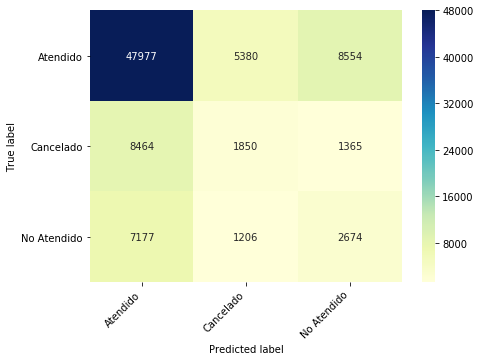

In [157]:
from sklearn.model_selection import cross_val_score
from sklearn.metrics import confusion_matrix

y_pred_normalized = clf.predict(df_test_normalized)
class_numbers_normalized = datos_num_test_labels.unique()
class_numbers_normalized.sort()
class_names_normalized = le.inverse_transform(class_numbers)
cm_normalized = confusion_matrix(datos_num_test_labels,y_pred_normalized)
cm_fig_normalized = print_confusion_matrix(cm_normalized,class_names_normalized)

Intentamos ahora con una variante de la SVM con penalización en la holguras que, a diferencia de la anterior definida, esta consta de tres constantes $C_1>0,C_2>0,C_4>0$, las cuales van asociadas a aquellos datos con etiquetas iguales al subíndice de la constante. Esto debido a que, al variar la constante $C$ uniformemente en las etiquetas, no se lograban cambios significativos y, o continuaba la predicción concentrada en $'Atendido'$ (como se describió anteriormente), o lograba muy poca precisión en el conjunto de datos en general.

El rendimiento de esta forma de realizar la clasificación eligiendoo $C_1=1, C_2=1.05, C_3=1.07$ fue de una precisión del 50.8%, y por etiquetas resulta un 57% para $'Atendido'$, un 39% para $'Cancelado'$ y un 29% para $'No Atendido'$. Además, demora un tiempo de 3.2 minutos.

%%latex


\begin{equation*}
\begin{aligned}
& \underset{w,b,\xi}{\text{minimize}}
& & \frac{1}{2}w^{T}w + C_1\sum_{i:y_i=1}^{n}\xi_{i}+ C_2\sum_{i:y_i=2}^{n}\xi_{i}+ C_4\sum_{i:y_i=4}^{n}\xi_{i} \\
& \text{subject to}
& & y_{i}(w^{T}x_{i}+b) \geq 1-\xi_{i} , \; i = 1, \ldots, n.\\
& & & \xi_{i} \geq 0
\end{aligned}
\end{equation*}

In [173]:
##weighted SVM: C_1 = 1, C_2 = 1.05, C_3 = 1.07.
start3 = time.time()
from sklearn.svm import SVC
clf = SVC(gamma='auto', class_weight= {1: 1, 2: 1.05, 4: 1.07})
clf.fit(df_training_normalized, y)
end3 = time.time()

In [174]:
start4 = time.time()
print(clf.score(df_test_normalized, datos_num_test_labels))
end4 = time.time()
print("el timepo de ejecución fue de", (end3+end4-start3-start4)/60 , " minutos.")

0.5084291233002942
el timepo de ejecución fue de 3.265847086906433  minutos.


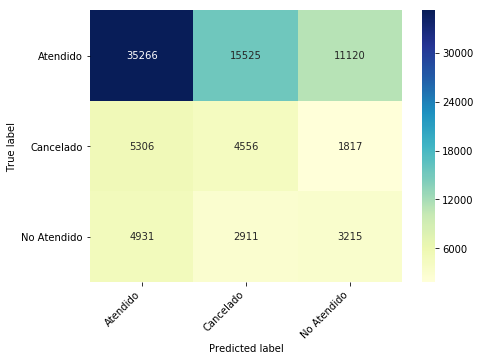

In [175]:
y_pred_normalized = clf.predict(df_test_normalized)
class_numbers_normalized = datos_num_test_labels.unique()
class_numbers_normalized.sort()
class_names_normalized = le.inverse_transform(class_numbers)
cm_normalized = confusion_matrix(datos_num_test_labels,y_pred_normalized)
cm_fig_normalized = print_confusion_matrix(cm_normalized,class_names_normalized)